In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

#Load the .csv file
#csv_file = 'C:\\Users\\Ashle\\OneDrive\\Desktop\\Lab codes\\2025 data\\carbenoxolone data\\carbenoxolone.csv' #ashleigh's personal computer
csv_file = 'C:\\Users\\lab\\Documents\\src\\Ashleigh\\Data 2025\\carbenoxolone data\\250729 carbenoxolone.csv' #lab computer

#Read CSV file
data = pd.read_csv(csv_file) #reads the file
print(data)

#all scoring has been reviewed, graphs reflet true data


          Time     0 TI     1 TE   2 TTot      3 VT     4 Max
0    1383.8989  0.86265  3.55436  4.41701  0.033439  0.053768
1    1388.3160  0.84313  3.26743  4.11056  0.032616  0.048096
2    1392.4265  0.80629  3.19921  4.00550  0.030352  0.043081
3    1396.4320  0.86167  3.67448  4.53615  0.030982  0.046931
4    1400.9682  0.84399  3.74957  4.59356  0.030442  0.042334
..         ...      ...      ...      ...       ...       ...
278  2694.8199  0.64685  4.70647  5.35332  0.020431  0.041836
279  2700.1732  0.69689  3.12087  3.81776  0.021852  0.042014
280  2703.9909  0.60441  3.40262  4.00703  0.019850  0.041920
281  2707.9980  0.70501  4.27387  4.97888  0.020435  0.037969
282  2712.9768  0.63231  4.01719  4.64950  0.021395  0.051628

[283 rows x 6 columns]


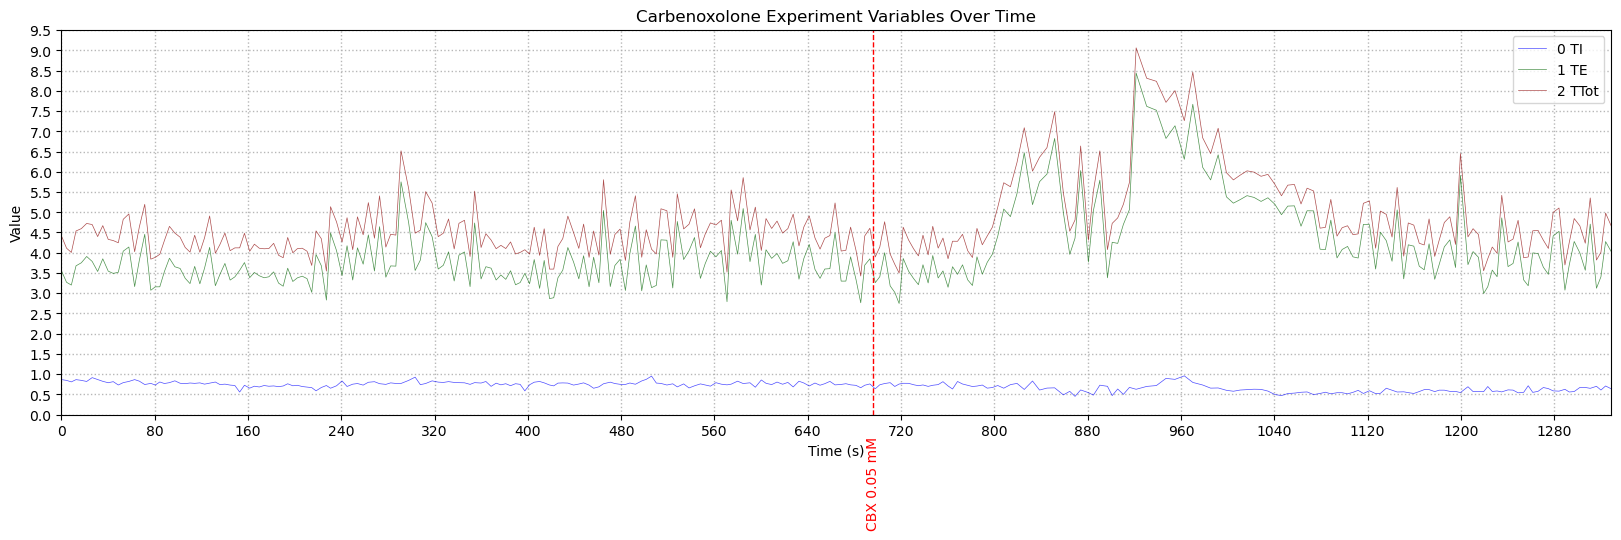

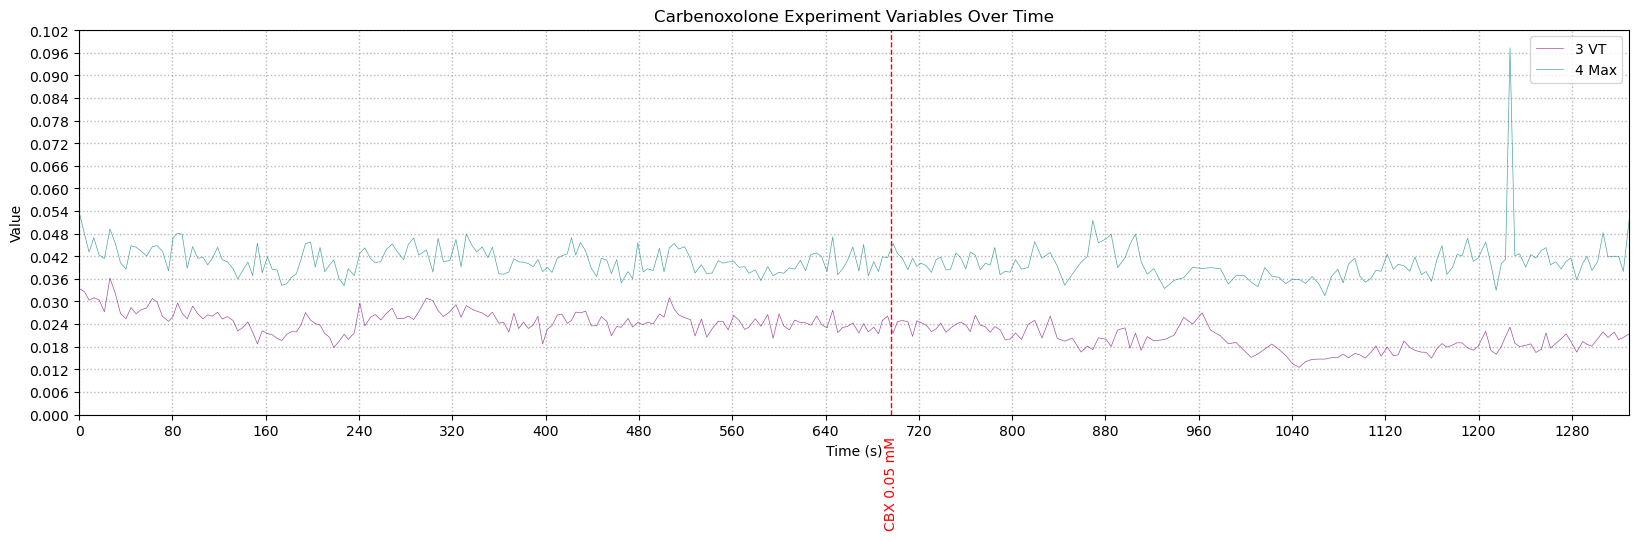

In [42]:
# group 1 variables plotted on same graph, group 2 variables plotted individually
group1 = ['0 TI', '1 TE', '2 TTot']
group2 = ['3 VT', '4 Max']

# color of data lines and trend lines for associated variables
colors_group1 = ['blue', 'darkgreen', 'darkred']
colors_group2 = ['purple', 'teal']

 
# First breath = time 0, and all subsequent times are shifted accordingly.
data = data.copy()  # copies data to avoid modifying original dataframe
data['Time_shifted'] = data['Time'] - data['Time'].iloc[0]

# special events to mark on the graph
special_events = [
    {'x': 2080, 'label': 'CBX 0.05 mM', 'color': 'red', 'linestyle': '--'},
    ]

# helper to draw labeled vertical lines at special events
def add_vline_with_label(ax, x, label, color='black', linestyle='--', y=-0.3, fontsize=10):
    plt.axvline(x=x, color=color, linestyle=linestyle, linewidth=1)
    plt.text(
        x=x,
        y=y,
        s=label,
        rotation=90,
        verticalalignment='bottom',
        horizontalalignment='center',
        fontsize=fontsize,
        color=color,
        transform=ax.get_xaxis_transform()
    )

# function to plot a group of variables
def plot_group(data, group, colors, special_events, xlim=None, ylim=None):

    x = data['Time_shifted']
    plt.figure(figsize=(20, 5))

    # plot each variable in the group
    for var, color in zip(group, colors):
        plt.plot(
            x,
            data[var],
            label=var,
            linewidth=0.5,
            alpha=0.7,
            color=color
        )

    ax = plt.gca()

    # add labeled special-event markers
    for ev in special_events:
        x_event_shifted = ev['x'] - data['Time'].iloc[0]   # shift event time the same way as the x-axis
        add_vline_with_label(
            ax,
            x_event_shifted,
            ev['label'],
            color=ev['color'],
            linestyle=ev['linestyle']
        )

    # grid behind graph
    plt.grid(True, which='both', linestyle=':', linewidth=1, alpha=0.9)

    # limit number of ticks to keep things readable
    ax.xaxis.set_major_locator(plt.MaxNLocator(20))
    ax.yaxis.set_major_locator(plt.MaxNLocator(20))

    # auto y-limits based on data range
    ylim = (0, max(data[group].max()) * 1.05)
    plt.ylim(ylim)

    # x-axis runs from 0 to last shifted time point
    xlim = (0, max(x))
    plt.xlim(xlim)

    plt.xlabel('Time (s)')
    plt.ylabel('Value')
    plt.title('Carbenoxolone Experiment Variables Over Time')
    plt.legend()

# make the two plots
plot_group(data, group1, colors_group1, special_events)
plot_group(data, group2, colors_group2, special_events)



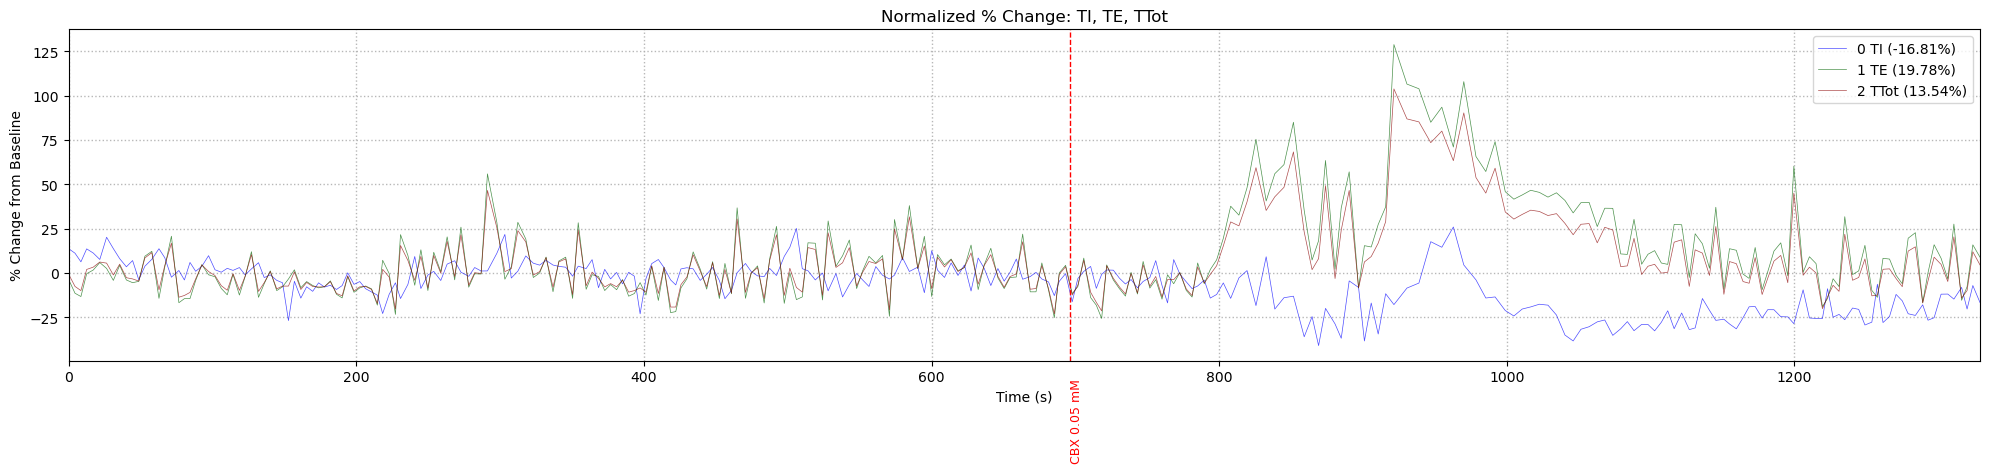

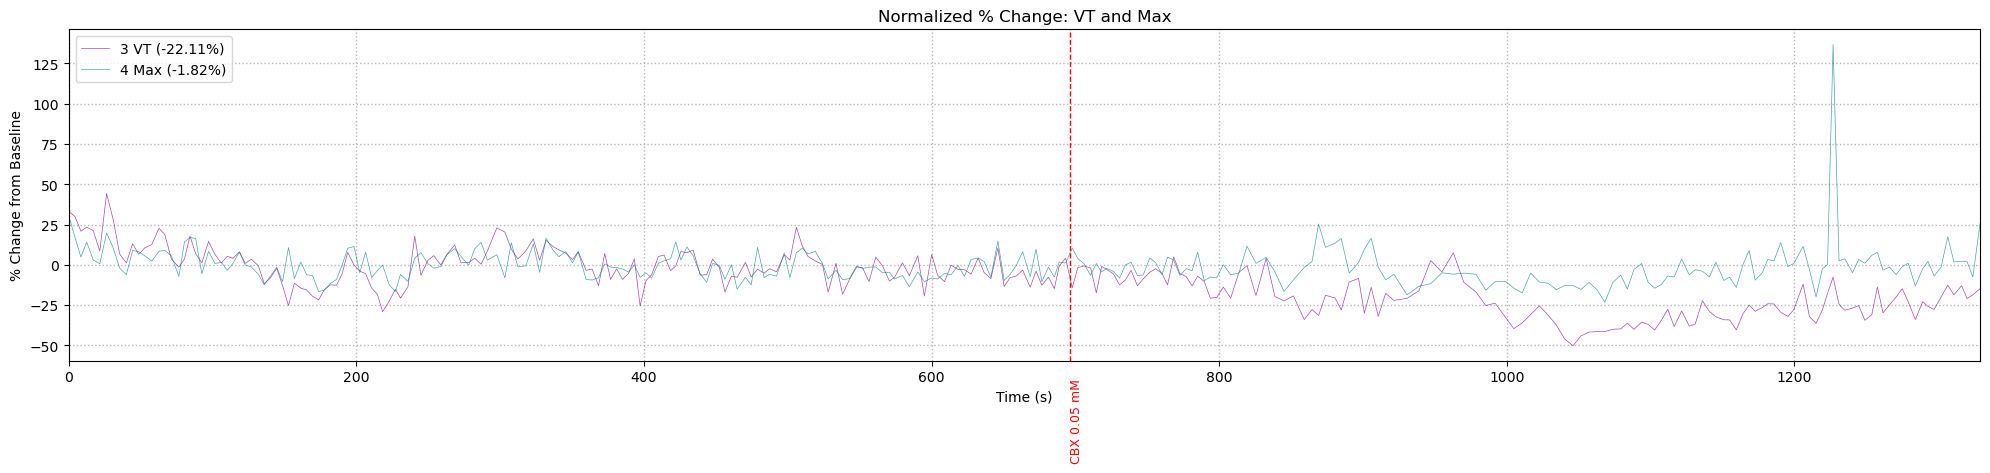

Normalized Mean % Change from Baseline:

0 TI: -16.81% change from baseline
1 TE: 19.78% change from baseline
2 TTot: 13.54% change from baseline
3 VT: -22.11% change from baseline
4 Max: -1.82% change from baseline


In [43]:
# baseline and postdrug windows in absolute time (seconds)
baseline_start_time = 1379
baseline_end_time   = 2080
postdrug_start_time = 2080
postdrug_end_time   = 2735

# convert these times to integer positions in the dataframe
baseline_start = data['Time'].searchsorted(baseline_start_time)
baseline_end   = data['Time'].searchsorted(baseline_end_time)
postdrug_start = data['Time'].searchsorted(postdrug_start_time)
postdrug_end   = data['Time'].searchsorted(postdrug_end_time)

# copy data for normalized percent change
normalized_data = data.copy()

# normalize variables to baseline mean
for var in group1 + group2:
    baseline_mean = data[var].iloc[baseline_start:baseline_end].mean()
    normalized_data[var] = (data[var] - baseline_mean) / baseline_mean * 100

# compute mean percent change in postdrug window
percent_changes = {
    var: normalized_data[var].iloc[postdrug_start:postdrug_end].mean()
    for var in group1 + group2
}

# shift x-axis so first time point = 0
x_shifted = data['Time'] - data['Time'].iloc[0]

# plotting function for normalized data
def plot_normalized(var_list, color_list, title, y_offset):
    plt.figure(figsize=(20, 5))
    for var, color in zip(var_list, color_list):
        plt.plot(
            x_shifted,
            normalized_data[var],
            label=f"{var} ({percent_changes[var]:.2f}%)",
            linewidth=0.5,
            alpha=0.7,
            color=color
        )
    ax = plt.gca()
    # add special events (shifted to match x-axis)
    for ev in special_events:
        x_event_shifted = ev['x'] - data['Time'].iloc[0]
        plt.axvline(x=x_event_shifted, color=ev['color'], linestyle=ev['linestyle'], linewidth=1)
        plt.text(x_event_shifted, y_offset, ev['label'],
                 rotation=90, transform=ax.get_xaxis_transform(),
                 fontsize=9, color=ev['color'])
    plt.grid(True, which='both', linestyle=':', linewidth=1, alpha=0.9)
    plt.xlim([0, max(x_shifted)])
    plt.xlabel('Time (s)')
    plt.ylabel('% Change from Baseline')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot group 1 variables together
plot_normalized(group1, colors_group1,'Normalized % Change: TI, TE, TTot', -0.3)

# Plot group 2 variables individually
plot_normalized(group2, colors_group2, 'Normalized % Change: VT and Max', -0.3)

# print percent changes
print("Normalized Mean % Change from Baseline:\n")
for var, change in percent_changes.items():
    print(f"{var}: {change:.2f}% change from baseline")


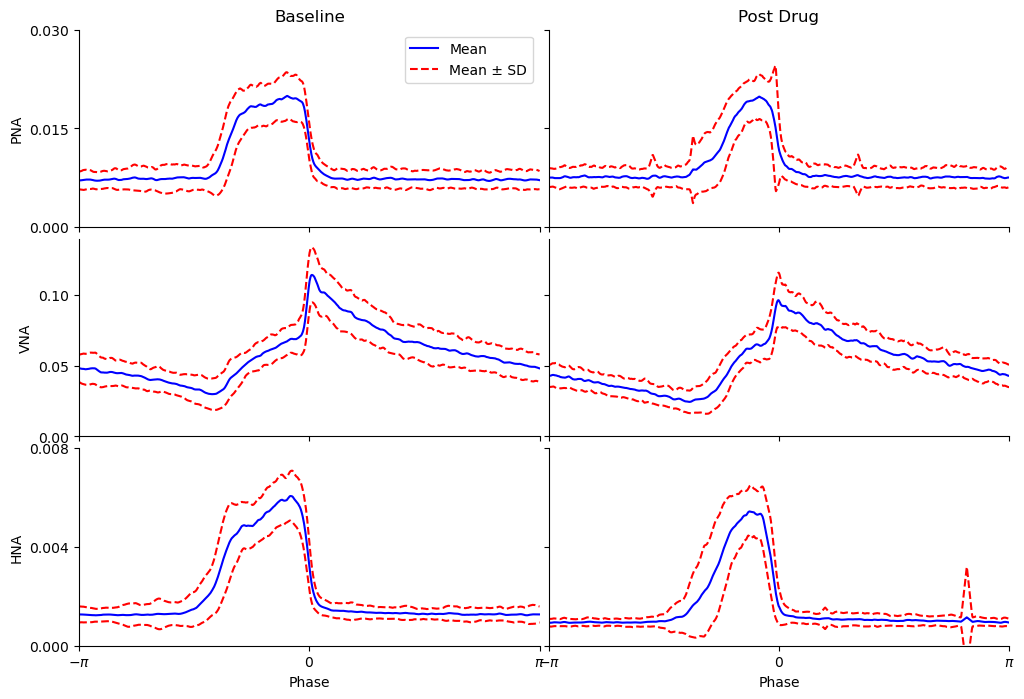

In [47]:
import neo
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import quantities as pq

# load baseline + post files
#file_base = r'C:\Users\Ashle\OneDrive\Desktop\Lab codes\2025 data\carbenoxolone data\250725 CBX 100 uM pt 1.smr'
#file_post = r'C:\Users\Ashle\OneDrive\Desktop\Lab codes\2025 data\carbenoxolone data\250725 CBX 100 uM pt 2.smr'

file = r'C:\Users\lab\Documents\src\Ashleigh\Data 2025\carbenoxolone data\250729 200 uL, 50 mM CBX AW.smr'
blk = neo.io.Spike2IO(file).read_block()

# time windows
baseline_window = (1379, 2080)
postdrug_window = (2080, 2735)

# preprocess function for both baseline and post
def preprocess(block, start, end):
    insp = block.segments[0].events[2]        # insp OFF times
    mp   = block.segments[0].analogsignals[1] # nerve channels
    fs   = float(mp.sampling_rate) #sampling rate in Hz

    # segment of interest
    i0 = int(start * fs)
    i1 = int(end * fs)

    # convert event times → samples
    evt_t = insp.times[(insp.times >= start) & (insp.times <= end)]
    evt_s = ((evt_t.rescale(pq.s).magnitude - start) * fs).astype(int)

    # extract the channels as numpy
    sig = np.array(mp[i0:i1, :])

    # high-pass filter (remove slow drift)
    high = 300
    b, a = butter(3, high, 'highpass', fs=fs)
    hp = filtfilt(b, a, sig, axis=0)

    # rectification
    rect = np.abs(hp)

    # smoothing
    tau = 50
    wn = max(1, int(tau * 1e-3 * fs))
    kernel = np.ones(wn) / wn
    smooth = filtfilt(kernel, [1], rect, axis=0, padtype='even')

    return smooth, evt_s, fs

# run preprocessing on both datasets
smooth_base, evt_base, fs = preprocess(blk, *baseline_window)
smooth_post, evt_post, fs = preprocess(blk, *postdrug_window)

# CTA function (same for baseline + post)
def CTA(smooth, evt):
    n_bins = 1000
    n_cycles = len(evt) - 1
    cta = np.zeros((n_cycles, 3, n_bins))

    # normalize each cycle to n_bins points
    for i in range(n_cycles):
        idx = np.linspace(evt[i], evt[i+1], n_bins, endpoint=False).astype(int)
        cta[i] = smooth[idx, :3].T

    # cycle average + std
    mean = np.mean(cta, axis=0)
    std  = np.std(cta, axis=0)

    # center the CTA on phase = 0
    shift = np.ceil(n_bins/2).astype(int)
    return np.roll(mean, shift, axis=1), np.roll(std, shift, axis=1)

# compute baseline + post CTAs
mean_base, std_base = CTA(smooth_base, evt_base)
mean_post, std_post = CTA(smooth_post, evt_post)

# phase axis
phi = np.linspace(-np.pi, np.pi, 1000)
labels = ['PNA', 'VNA', 'HNA']


fig, axes = plt.subplots(3, 2, figsize=(12, 8), sharex='col', sharey='row')
plt.subplots_adjust(wspace=0.02, hspace=0.06)

# column titles only once
axes[0, 0].set_title("Baseline")
axes[0, 1].set_title("Post Drug")

for ch in range(3):
    for col in range(2):
        ax = axes[ch, col]

        # baseline = column 0 ; post = column 1
        if col == 0:
            data_mean = mean_base[ch]
            data_std  = std_base[ch]
        else:
            data_mean = mean_post[ch]
            data_std  = std_post[ch]

        # CTA curves
        ax.plot(phi, data_mean, color='blue', label='Mean')
        ax.plot(phi, data_mean + data_std, color='red', linestyle='--', label = "Mean ± SD")
        ax.plot(phi, data_mean - data_std, color='red', linestyle='--')

        ax.set_xlim([-np.pi, np.pi])

        # exactly 3 ticks on x-axis
        ax.set_xticks([-np.pi, 0, np.pi])
        if ch < 2:
            ax.set_xticklabels([])
        else:
            ax.set_xticklabels([r'$-\pi$', r'$0$', r'$\pi$'])
            ax.set_xlabel("Phase")

        # y label only on left
        if col == 0:
            ax.set_ylabel(labels[ch])
        # else:
            # ax.set_yticklabels([])

# one legend only

axes[0, 0].legend()

# axes[0,0].set_ylim([0.001, 0.0045])
# axes[1,0].set_ylim([0.00, 0.12])
axes[2,0].set_ylim([0, 0.006])
axes[0,0].set_yticks(np.linspace(0, 0.03, 3))
axes[1,0].set_yticks(np.linspace(0.00, 0.1, 3))
axes[2,0].set_yticks(np.linspace(0, 0.008, 3))

for r in axes:
    for ax in r:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

# plt.savefig('something.svg', bbox_inches='tight')
